# **TRABAJO DE FIN DE MASTER - MASTER EN INTELIGENCIA ARTIFICIAL**
**María Soledad Murias Palomer**

El objetivo de este trabajo es crear un modelo que permita predecir la venta futura por tienda de una serie de productos y, a partir de ella, optimizar el inventario de cada tienda dadas ciertas restricciones de espacio y reposición.

El Notebook 4 tomará el modelo de forecast elegido en el Notebook 2 y los datos obtenidos del Notebook 3 para generar una predicción de la venta por local/categoría. Esta predicción alimentará al optimizador de inventario del Notebook 5.

In [ ]:
# Importación de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

!pip install xgboost
import xgboost as xgb


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## PRPARACIÓN DE DATOS



In [ ]:
# Importación de datos
file1 = "dataframe2.csv" # Archivo con las columnas adicionales de One Hot Encoding
data_stnd = pd.read_csv(file1)

In [ ]:
data_stnd.set_index('Fecha', inplace=True)
data_stnd.head()

,Dia Sem,Sem del año,Uns,PrecioUnit,Cliente,New_Cluster,Feriado_FERIADO,Feriado_IRRENUNCIABLE,Feriado_NORMAL,Evento_DIAMADRE,...,New_Cluster_GUANTE_ZAPATO_ZAPATILLA_ST,New_Cluster_GUANTE_ZAPATO_ZAPATO,New_Cluster_GUANTE_ZAPATO_ZAPATO_CASUAL_CT,New_Cluster_GUANTE_ZAPATO_ZAPATO_CASUAL_ST,New_Cluster_GUANTE_ZAPATO_ZAPATO_ESCOLAR,New_Cluster_GUANTE_ZAPATO_ZAPATO_FORMAL_CT,New_Cluster_GUANTE_ZAPATO_ZAPATO_FORMAL_ST,New_Cluster_GUANTE_ZAPATO_ZAPATO_INFORMAL_CT,New_Cluster_GUANTE_ZAPATO_ZAPATO_INFORMAL_ST,New_Cluster_GUANTE_ZAPATO_ZAPATO_OUTDOOR
Fecha,,,,,,,,,,,,,,,,,,,,,
2023-01-01,7,1,0,0.0,GACEL ESTADO,GACEL_ALPARGATA_ALPARGATA_CASUAL,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01,7,1,0,0.0,GACEL ESTADO,GACEL_BALLERINA_BALLERINA_VESTIR,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01,7,1,0,0.0,GACEL ESTADO,GACEL_BILLETERA_BILLETERA,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01,7,1,0,0.0,GACEL ESTADO,GACEL_BOLSO_BOLSO,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01,7,1,0,0.0,GACEL ESTADO,GACEL_BOOTIE_BOOTIE_CASUAL_BAJA,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_stnd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 928575 entries, 2023-01-01 to 2025-02-20
Columns: 233 entries, Dia Sem to New_Cluster_GUANTE_ZAPATO_ZAPATO_OUTDOOR
dtypes: float64(228), int64(3), object(2)
memory usage: 1.6+ GB


## PREDICCIÓN DE VENTA
En esta sección se realizarán el forecast de venta con tres modelos para posterior comparación. Utilizaremos la clasificación de productos entregada por la empresa.

Los modelos a utilizar son: XGBoost, SARIMA y LS



In [ ]:
def calc_stat(y_real,y_pred):
  y_mean = y_real.mean()
  ss_total = ((y_real - y_mean) ** 2).sum()
  ss_residual = ((y_real - y_pred) ** 2).sum()
  r2 = 1 - (ss_residual / ss_total)
  rmse = np.sqrt(((y_real - y_pred) ** 2).mean())
  epsilon = 1e-6
  mape = (np.abs((y_real - y_pred) / (y_real+epsilon))).mean() * 100

  return r2, rmse, mape

In [ ]:
data_stnd.index = pd.to_datetime(data_stnd.index)

# Haremos un loop que recorra las filas del DataFrame hasta encontrar en el índice el año 2025
indice_primera_fila = 0
for index, row in data_stnd.iterrows():
    if index.year == 2025:
        break
    indice_primera_fila += 1

print(indice_primera_fila)

868889


In [ ]:
total_filas = len(data_stnd)
val = indice_primera_fila
train = int(val*0.8)
print(total_filas, train, val)

928575 695111 868889


### XGBoost

In [ ]:
data_xgb = data_stnd.copy()

In [ ]:
dtrain = data_xgb.iloc[:train]
dval = data_xgb.iloc[train:val]
dtest = data_xgb.iloc[val:]

In [ ]:
# Definir variables predictoras y objetivo
X1_train = dtrain.drop(columns=['Uns','Cliente','New_Cluster'])
y1_train = dtrain['Uns']
X1_val = dval.drop(columns=['Uns','Cliente','New_Cluster'])
y1_val = dval['Uns']
X1_test = dtest.drop(columns=['Uns','Cliente','New_Cluster'])
y1_test = dtest['Uns']

In [ ]:
# Crear DMatrix para XGBoost
dmtrain = xgb.DMatrix(X1_train, label=y1_train)
dmval = xgb.DMatrix(X1_val, label=y1_val)
dmtest = xgb.DMatrix(X1_test, label=y1_test)

In [ ]:
# Definir parámetros del modelo
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 4,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

In [ ]:
# Entrenar el modelo
model = xgb.train(params, dmtrain, num_boost_round=1000, evals=[(dmval, 'test')], early_stopping_rounds=10)

[0]	test-rmse:2.69814
[1]	test-rmse:2.67387
[2]	test-rmse:2.64153
[3]	test-rmse:2.62752
[4]	test-rmse:2.61133
[5]	test-rmse:2.58349
[6]	test-rmse:2.55521
[7]	test-rmse:2.53803
[8]	test-rmse:2.51396
[9]	test-rmse:2.49506
[10]	test-rmse:2.48246
[11]	test-rmse:2.46380
[12]	test-rmse:2.45190
[13]	test-rmse:2.43521
[14]	test-rmse:2.42561
[15]	test-rmse:2.41087
[16]	test-rmse:2.39594
[17]	test-rmse:2.39073
[18]	test-rmse:2.37541
[19]	test-rmse:2.36349
[20]	test-rmse:2.35849
[21]	test-rmse:2.34703
[22]	test-rmse:2.33776
[23]	test-rmse:2.32900
[24]	test-rmse:2.32165
[25]	test-rmse:2.31653
[26]	test-rmse:2.31197
[27]	test-rmse:2.30622
[28]	test-rmse:2.29972
[29]	test-rmse:2.29283
[30]	test-rmse:2.28674
[31]	test-rmse:2.28237
[32]	test-rmse:2.27766
[33]	test-rmse:2.27359
[34]	test-rmse:2.26612
[35]	test-rmse:2.26099
[36]	test-rmse:2.25648
[37]	test-rmse:2.25233
[38]	test-rmse:2.24863
[39]	test-rmse:2.24533
[40]	test-rmse:2.24112
[41]	test-rmse:2.23639
[42]	test-rmse:2.23022
[43]	test-rmse:2.2274

In [ ]:
# Predicción
y1_pred = model.predict(dmtest)

r2_xgb, rmse_xgb, mape_xgb = calc_stat(y1_test, y1_pred)

# Mostrar resultados
print(f"R2: {r2_xgb:,.4f}")
print(f"RMSE: {rmse_xgb:,.4f}")
print(f"MAPE: {mape_xgb:,.4f}")

R2: 0.4241
RMSE: 1.5855
MAPE: 1,063,278.8415


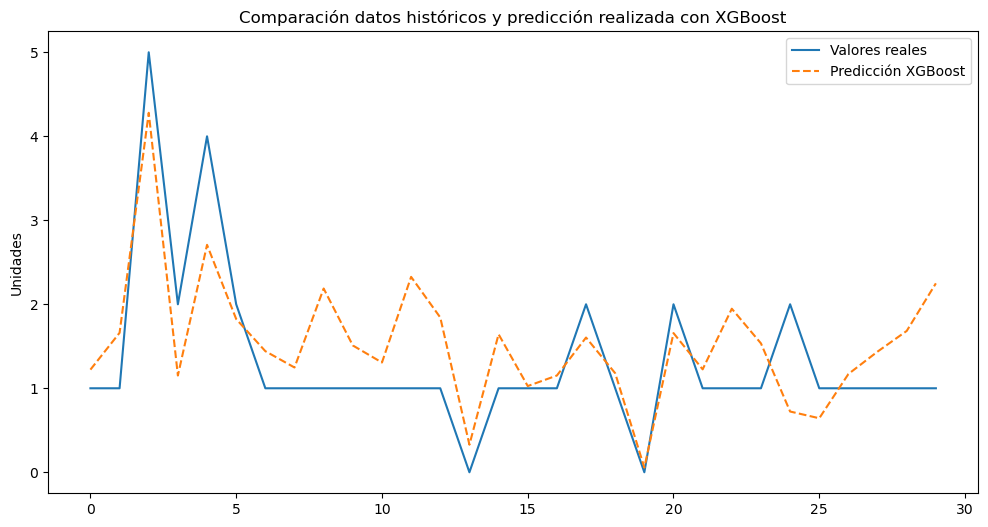

In [ ]:
# Graficar predicción y datos reales
plt.figure(figsize=(12, 6))
plt.plot(y1_test[-30:].values, label='Valores reales', color='#1f77b4')
plt.plot(y1_pred[-30:], label='Predicción XGBoost', color='#ff7f0e', linestyle='dashed')
plt.title('Comparación datos históricos y predicción realizada con XGBoost')
plt.ylabel('Unidades')
plt.legend()
plt.show()

In [ ]:
epsilon = 1e-6

df = pd.DataFrame({
    'y1_test': y1_test,
    'y1_pred': y1_pred,
})

df['mape'] = mape = np.abs((df['y1_test'] - df['y1_pred']) / (df['y1_test'] + epsilon)) * 100

# Ordenar el DataFrame por MAPE de forma descendente
df_sorted = df.sort_values(by='mape', ascending=False)
print(df_sorted[:20])

            y1_test   y1_pred          mape
Fecha                                      
2025-01-09        0  2.165487  2.165487e+08
2025-01-29        0  2.061896  2.061896e+08
2025-01-02        0  2.048885  2.048885e+08
2025-02-15        0  2.033848  2.033848e+08
2025-01-16        0  1.987144  1.987144e+08
2025-02-10        0  1.897197  1.897197e+08
2025-01-06        0  1.886871  1.886871e+08
2025-01-17        0  1.865913  1.865913e+08
2025-01-04        0  1.744502  1.744502e+08
2025-02-14        0  1.727165  1.727165e+08
2025-01-08        0  1.670955  1.670955e+08
2025-02-13        0  1.662530  1.662530e+08
2025-01-07        0  1.649864  1.649864e+08
2025-01-04        0  1.649050  1.649050e+08
2025-02-19        0  1.544402  1.544402e+08
2025-02-01        0  1.537372  1.537372e+08
2025-02-20        0  1.485731  1.485731e+08
2025-01-04        0  1.484793  1.484793e+08
2025-02-08        0  1.475758  1.475758e+08
2025-01-05        0  1.431286  1.431286e+08


In [ ]:
m = 1

# Numerador: Error absoluto del modelo
error_modelo = np.abs(y1_test - y1_pred)

# Denominador: Error absoluto del modelo naive (referencia), usando el valor del periodo anterior
error_referencia = np.abs(y1_test[m:] - y1_test[:-m])

# Calcular MASE (Media de los errores absolutos del modelo, escalados por el error de referencia)
mase = error_modelo[m:].sum() / error_referencia.sum()

print(f"MASE: {mase:,.4f}")

# Calcular WAPE (error absoluto ponderado)
error_absoluto = np.abs(y1_test - y1_pred)  # Error absoluto
suma_y_test = np.abs(y1_test).sum()  # Suma de los valores reales

# WAPE es el error absoluto total dividido por la suma de los valores reales
wape = (error_absoluto.sum() / suma_y_test) * 100

print(f"WAPE: {wape:,.4f}%")

MASE: 0.0005
WAPE: 46.8282%


In [ ]:
model.save_model("xgboost_model2.json")